In [44]:
#Set working directory
setwd("~/U_of_H/FALL_2021/Data_ARMS")

#load necessary packages
library("dplyr")
library("ggplot2")
library("data.table")
library ("magrittr")
library("plyr")
library("reshape2")
library("tidyr")
library("RColorBrewer")
library("colorRamps")
library("vegan")
library("indicspecies")
library("stats")

## upload 3 files:  taxonomy table, ASV table and meta data 

In [45]:

read_3_files <- function (taxonomy_df, Abundance_ASV_df, meta_data_df) { 
    
    taxonomy_DNA <- as.data.frame(fread(taxonomy_df))
    ASV_table_DNA <- as.data.frame(fread (Abundance_ASV_df, header = TRUE))
    metadata_df_DNA <- as.data.frame(fread (meta_data_df))
 
    #set row.names properly for taxonomy and ASV and metadata files
    rownames(ASV_table_DNA) <- ASV_table_DNA$ID_ASV
    rownames(taxonomy_DNA) <- taxonomy_DNA$ID_ASV
    rownames(metadata_df_DNA) <- metadata_df_DNA$Sample  
    
    assign("taxonomy_DNA", taxonomy_DNA, envir = .GlobalEnv)
    assign("ASV_table_DNA", ASV_table_DNA, envir = .GlobalEnv)
    assign("metadata_df_DNA", metadata_df_DNA, envir = .GlobalEnv)
    
}  

read_3_files("Assignation_Taxonomique_MBIO612_ARMS_COI_GM.csv", "ASV_Table_Abondance_nochim_MBIO612_ARMS_GM.csv", "GabyMetaData_ARMS_COI_2021.csv")

## Merge full tables

In [46]:

merge_full_table <- function (taxonomy_DNA, ASV_table_DNA) {
    
    #Merge Taxonomy and ASV tables into a new object
    combined_table <- join(taxonomy_DNA, ASV_table_DNA)
    rownames(combined_table) <- rownames(ASV_table_DNA)


    #delete useless ID_ASV column for taxonxomy and ASV tables
    ASV_table_DNA$ID_ASV <- NULL
    taxonomy_DNA$ID_ASV <- NULL
    combined_table$ID_ASV <- NULL
    
     assign("combined_table", combined_table, envir = .GlobalEnv)
    
    }

merge_full_table(taxonomy_DNA, ASV_table_DNA)

Joining by: ID_ASV


## Tables data wrangling

In [47]:
#Remove the ASVs that haven't been classified up to the desired taxonomic level (ex: exclude ASV that haven't been anotated to the phylum level)

combine_tax_abundance <- function (combined_full_df, taxa_col) {
    
    combined_df_working <- combined_full_df %>%  filter({{taxa_col}} != "")
    
    assign ("combined_df_working", combined_df_working , envir = .GlobalEnv)
    
      }

combine_tax_abundance(combined_table, phylum)

In [48]:
#flip the taxonomic/abundance

flip_df <- function (df) {
    
    flipped_df_working <- data.frame (t(df))
    
     assign ("flipped_df_working", flipped_df_working, envir = .GlobalEnv)
    
     }

flip_df(combined_df_working)

In [49]:
#Merge meta data

merge_df <- function (flipped_df, meta_data,  by_row_col) {
    
    
     combined_full_df <- flip_df(flipped_df)
    
     combined_df_Meta_data <- merge (combined_full_df, meta_data, by= substitute(by_row_col), all.y = T)
    
    assign ("combined_df_Meta_data", combined_df_Meta_data, envir = .GlobalEnv)
    
     }

merge_df(combined_df_working, metadata_df_DNA, "row.names")

In [50]:
#Subset Meta data from working df

subset_df_nested <- function (full_df, subset_df) {
    
    Meta_data_working_df <- full_df [,full_df %in% subset_df]
    Meta_data_working_df$Row.names <- row.names(subset_df)
    
    assign("Meta_data_working_df", Meta_data_working_df, envir = .GlobalEnv)
    
     }

subset_df_nested (combined_df_Meta_data, metadata_df_DNA)

In [51]:
#Subset ASV abundance from working df

subset_numeric_df <- function (full_df) {
    
    ASV_DNA_working_df <- full_df [sapply(full_df, is.numeric)]
    assign("ASV_DNA_working_df", ASV_DNA_working_df, envir = .GlobalEnv)
    
    
     }

subset_numeric_df (combined_df_working)

In [52]:
#Subset taxonomy from working df

subset_join <- function (full_df, subset_df) {
    
    taxonomy_DNA_working_df <- semi_join(subset_df, full_df)
    assign("taxonomy_DNA_working_df", taxonomy_DNA_working_df, envir = .GlobalEnv)
    
     }

subset_join (combined_df_working, taxonomy_DNA)

Joining, by = c("kingdom", "phylum", "class", "order", "family", "genus", "species")


In [53]:
#long version of the table

elongate_df <- function (full_df, names_df) {
    
    long_combined_ASV_Meta_data_df <- melt(full_df, id= names (names_df))

    assign("long_combined_ASV_Meta_data_df", long_combined_ASV_Meta_data_df, envir = .GlobalEnv)
    
     }

elongate_df(combined_df_Meta_data, Meta_data_working_df)

Warning message:
"attributes are not identical across measure variables; they will be dropped"

In [54]:
 #merge flipped ASV_table working with meta data: no taxonomy

flipped_df_subset <- function (full_df, meta_data_df) {
    
    t_ASV_table_DNA_working <- flip_df (full_df)
    
    metadata_df <- meta_data_df %>%
    mutate_all(as.character)
    
    row.names(metadata_df)<- metadata_df$Sample

    flipped_ASV_Meta_data_working <- na.omit(merge(t_ASV_table_DNA_working, metadata_df, by="row.names",all.y=T))

    rownames(flipped_ASV_Meta_data_working) <- flipped_ASV_Meta_data_working[,1]

    flipped_ASV_Meta_data_working$Row.names <- NULL
    
    assign("flipped_ASV_Meta_data_working_df", flipped_ASV_Meta_data_working, envir = .GlobalEnv)
    assign("t_ASV_table_DNA_working",  t_ASV_table_DNA_working,  envir = .GlobalEnv)


     }

flipped_df_subset(ASV_DNA_working_df, metadata_df_DNA)

In [55]:
#Subset so no more meta data: flipped ASV table

subset_no_character_df <- function (full_df) {
    
    flipped_ASV_DNA_working_df <- full_df [!(sapply(full_df, is.character))]
    
    assign("flipped_ASV_DNA_working_df",  flipped_ASV_DNA_working_df, envir = .GlobalEnv)
    
    
     }

subset_no_character_df(flipped_ASV_Meta_data_working_df)

In [56]:
#flipped meta data
   
subset_character_df <- function (full_df) {
    
    flipped_Meta_data_working_df <- full_df [(sapply(full_df, is.character))]
    
    assign("flipped_Meta_data_working_df", flipped_Meta_data_working_df, envir = .GlobalEnv)
    
     }

subset_character_df(flipped_ASV_Meta_data_working_df)


## Barplot for taxonomic diversity

In [57]:
#Function : select the 20 most abundant taxa (ex:families) and combute the abundance of ASV for each of them

#select the taxa column
 extract_taxa_col <- function (working_taxonomy_table, taxa_col) {
    
   taxonomy_taxa <- working_taxonomy_table %>% 
    select ((.data[[taxa_col]]))
    
    taxonomy_taxa["variable"] <- row.names(taxonomy_taxa)
     
    assign("taxonomy_taxa", taxonomy_taxa, envir = .GlobalEnv)
     
      }

extract_taxa_col(taxonomy_DNA_working_df, "family")


In [58]:
#Add the taxa col to the elongated table

add_extracted_taxa_long_df <- function (long_df, working_taxonomy_table, taxa, by_variable) {
    
    taxa_col <- extract_taxa_col(working_taxonomy_table, taxa)
    
  
    Extracted_taxa_long_df <- merge (long_df, taxa_col, by= substitute(by_variable))
    
    
    Extracted_taxa_long_df <- data.frame (Extracted_taxa_long_df, stringsAsFactors = TRUE)

   
    Extracted_taxa_long_df [,by_variable] <- factor(Extracted_taxa_long_df[,by_variable])

   
    assign("Extracted_taxa_long_df", Extracted_taxa_long_df, envir = .GlobalEnv)
    
     }

add_extracted_taxa_long_df (long_combined_ASV_Meta_data_df, taxonomy_DNA_working_df, "family", "variable")

In [59]:
#Select only the data that is anotated to the given taxa level

    select_taxa_only <- function (combined_full_df, taxa) {
    
    long_taxa_ASV_df <- combine_tax_abundance (combined_full_df, {{taxa}})
    
    #Make the value column numeric
    
    long_taxa_ASV_df[,"value"] <- as.integer(long_taxa_ASV_df[,"value"])

    assign("long_taxa_ASV_df",  long_taxa_ASV_df, envir = .GlobalEnv)
    
      }

select_taxa_only(Extracted_taxa_long_df, family)

In [60]:
##Select the 20 most abundant families/phylum (taxa) and label and combine the other ones as other labelled the "others" together

subset_20_most_abundant_and_others <- function (Taxa_only_df, taxa_name) {

Taxa_ASV_abundant <- Taxa_only_df %>%
  group_by({{taxa_name}}) %>%
  drop_na() %>%
  dplyr::summarize (sum_asv= sum(value)) %>%
  arrange(desc(sum_asv)) %>%
  mutate (sum_asv_cumul =  if_else (row_number (sum_asv)< (length(sum_asv)-19), "Other", as.character(sum_asv))) %>%
  mutate(sum_asv = replace(sum_asv, sum_asv_cumul == "Other", sum(sum_asv[sum_asv_cumul == "Other"]))) 

    assign("Taxa_ASV_abundant",  Taxa_ASV_abundant, envir = .GlobalEnv)
}

subset_20_most_abundant_and_others(long_taxa_ASV_df, family)

In [61]:
#Replace the last 20 families by others

Group_others <- function (Taxa_only_df, taxa_name) {
    
    length_df <- nrow (Taxa_only_df)
    
    Taxa_only_df[21:length_df, taxa_name] <- "Other"
    
    Taxa_ASV_abundant_other <- Taxa_only_df
    
    assign("Taxa_ASV_abundant_other",  Taxa_ASV_abundant_other, envir = .GlobalEnv)
}

Group_others(Taxa_ASV_abundant, "family")

In [62]:
#Add meta data to families

add_meta_data <- function (Taxa_df, meta_data, taxa_name) {
    
    Taxa_df_Meta_data <- merge(Taxa_df, meta_data, by= substitute(taxa_name))
    
    Taxa_df_Meta_data [,"sum_asv_cumul"] <- NULL
    
    assign("Taxa_df_Meta_data",  Taxa_df_Meta_data, envir = .GlobalEnv)
  
}

add_meta_data(long_taxa_ASV_df, Taxa_ASV_abundant_other, "family")

In [70]:
#Find the mean number of ASV per taxa per factor 

calculate_mean_ASV_factor<- function (meta_data_ASV_df, taxa_name, factor_col) {
    
 meta_data_ASV_df[,"value"] <- as.numeric(meta_data_ASV_df[,"value"])
    
    
    ASV_per_group_per_taxa <- meta_data_ASV_df %>%
       dplyr::group_by(.data[[factor_col]], .data[[taxa_name]]) %>%
       dplyr::summarize(mean_abundance_ASV_group =  mean(value,na.rm=T))
    
    assign("ASV_per_group_per_taxa",  ASV_per_group_per_taxa, envir = .GlobalEnv)
}
 
calculate_mean_ASV_factor(Taxa_df_Meta_data, "family", "Island")

`summarise()` has grouped output by 'Island'. You can override using the `.groups` argument.


In [74]:
#calculate mean number of ASV per sample per factor

calculate_mean_ASV_factor_ps_sample <- function (meta_data_ASV_df, ASV_col, factor_col) {
    
    ASV_per_group <- meta_data_ASV_df %>%
       dplyr::group_by(.data[[ASV_col]], .data[[factor_col]]) %>%
        dplyr::summarize(sum_abundance_ASV_factor = sum(value, na.rm = T))
    
    
    
    Mean_ASV_per_sample_for_ea_factor <- ASV_per_group %>%
    dplyr::group_by(.data[[factor_col]]) %>%
    dplyr::summarize (mean_abundance_ASV_factor = mean(sum_abundance_ASV_factor, na.rm= TRUE))
    
    assign("ASV_per_group",  ASV_per_group, envir = .GlobalEnv)
    assign("Mean_ASV_per_sample_for_ea_factor", Mean_ASV_per_sample_for_ea_factor, envir = .GlobalEnv)

}

calculate_mean_ASV_factor_ps_sample(Taxa_df_Meta_data, "variable", "Island")

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.


In [72]:
#merge the two data frames

merge_factor_barplot <- function (mean_ASV_factor_df, factor_taxa_df, factor_name) {
    
    factor_barplot_df <- merge (mean_ASV_factor_df, factor_taxa_df, by= substitute(factor_name))
    
    assign("factor_barplot_df", factor_barplot_df, envir = .GlobalEnv)

    
}

merge_factor_barplot(Mean_ASV_per_sample_for_ea_factor, ASV_per_group_per_taxa, "Island")

In [24]:
#Make and extend color palette for graph

make_color_palette <- function (number_palette, number_taxa) {
    
    color_barplot <- brewer.pal(number_palette, "Paired") 
    
    color_barplot <-  colorRampPalette(color_barplot)(number_taxa)
    
    assign("color_barplot", color_barplot, envir = .GlobalEnv)
    
}

make_color_palette(12,21)

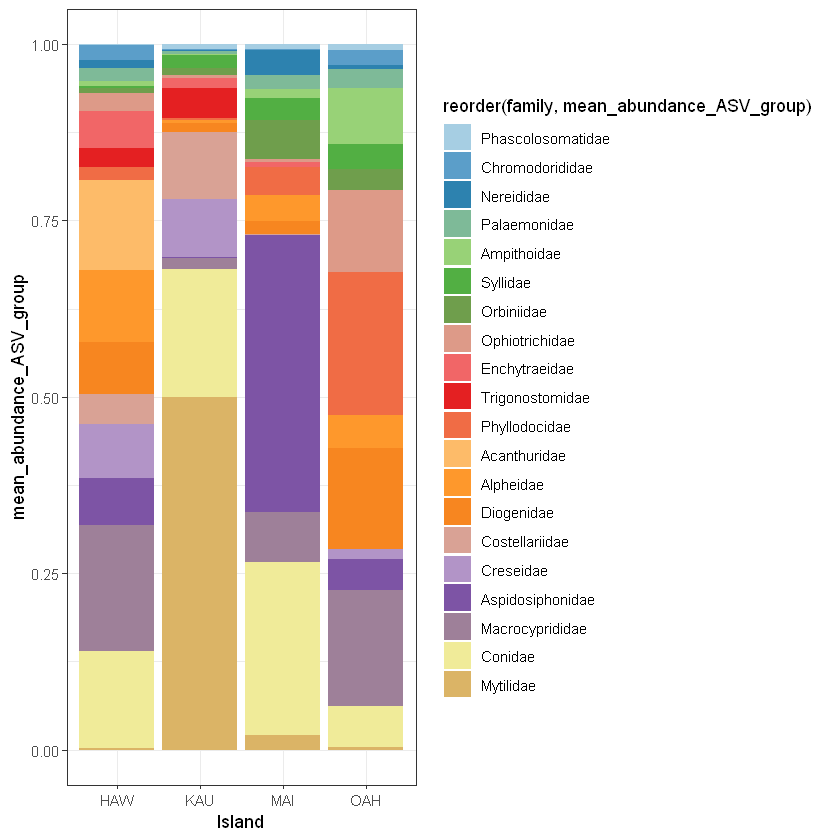

In [25]:
#plot

plot_taxonomic_barplot <- function (barplot_data_df, color_palette, taxa_name, factor) {
    
taxonomic_barplot <-ggplot(barplot_data_df, aes (fill = reorder(.data[[taxa_name]], mean_abundance_ASV_group), y= mean_abundance_ASV_group, x= .data[[factor]]))+
    
    geom_bar (position="fill",  stat= "identity") + theme_bw() +
    
    scale_fill_manual(values=color_palette)
    
    taxonomic_barplot
    
}

plot_taxonomic_barplot(factor_barplot_df, color_barplot, "family", "Island")

## Beta diversity analysis (PERMANVOA + NMDS)

In [26]:
#compute PERMANVOA function

compute_PERMANOVA <- function (ASV_df, grouping_factor, data_df, method_distance) {
    
    factor = data_df[,grouping_factor]
  
    PERMANOVA <- adonis (ASV_df ~ factor, data= data_df, permutations = 9999, method = {{method_distance}}, na.rm=T)
    
    return (PERMANOVA)
}

compute_PERMANOVA (flipped_ASV_DNA_working_df, "Island", flipped_ASV_Meta_data_working_df, "bray")


Call:
adonis(formula = ASV_df ~ factor, data = data_df, permutations = 9999,      method = {         {             method_distance         }     }, na.rm = T) 

Permutation: free
Number of permutations: 9999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
factor      3     6.196 2.06548  5.1845 0.11559  1e-04 ***
Residuals 119    47.408 0.39839         0.88441           
Total     122    53.605                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [27]:
#obtain distance matice for NMDS 1 and 2

compute_distance_dissimilarity_matrice <- function (ASV_df, method_distance, Meta_data) {
    
    distances <- vegdist(ASV_df, method= {{method_distance}}, na.rm=T)
    
    coordinates <- metaMDS(distances)

    scores_table <- as.data.frame(scores(coordinates))
    
    scores_table_NMDS <- merge(scores_table, Meta_data, by="row.names", all.x=T)
    
    assign("scores_table_NMDS", scores_table_NMDS, envir = .GlobalEnv)
    
  
    
}

compute_distance_dissimilarity_matrice(flipped_ASV_DNA_working_df, "bray", flipped_Meta_data_working_df)

Run 0 stress 0.2569125 
Run 1 stress 0.262539 
Run 2 stress 0.2820639 
Run 3 stress 0.2894446 
Run 4 stress 0.260483 
Run 5 stress 0.2714422 
Run 6 stress 0.2791174 
Run 7 stress 0.2761738 
Run 8 stress 0.2676732 
Run 9 stress 0.2574045 
... Procrustes: rmse 0.01913475  max resid 0.1061373 
Run 10 stress 0.2759828 
Run 11 stress 0.2597715 
Run 12 stress 0.2901057 
Run 13 stress 0.2692396 
Run 14 stress 0.2788221 
Run 15 stress 0.26689 
Run 16 stress 0.2787053 
Run 17 stress 0.2696134 
Run 18 stress 0.2612726 
Run 19 stress 0.264994 
Run 20 stress 0.2790617 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


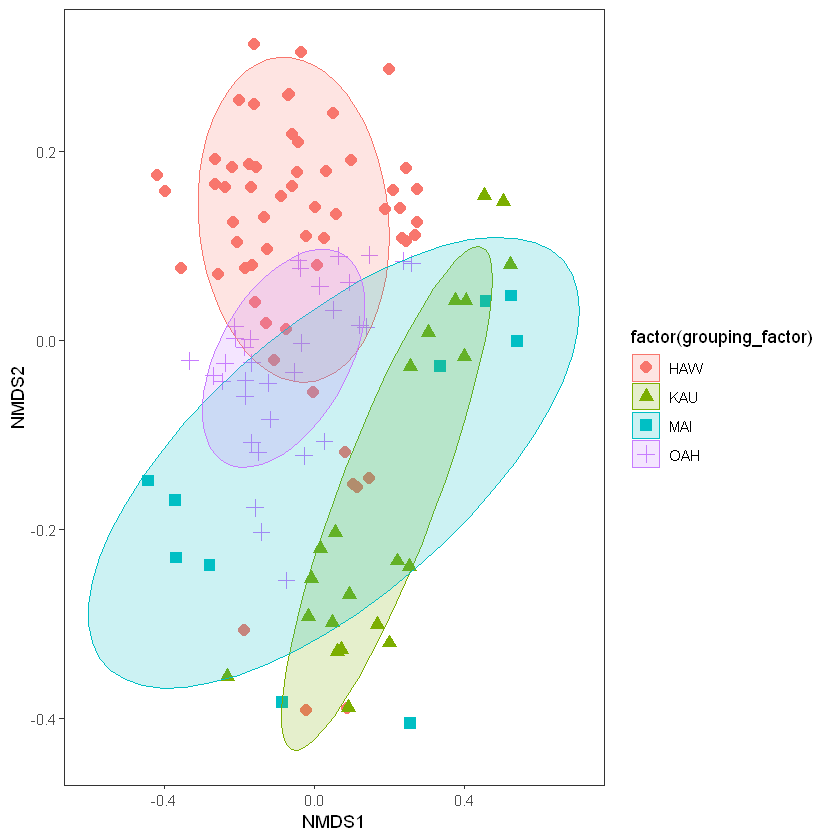

In [28]:
#Plot NMDS

plot_NMDS <- function (scores_table_meta_data_df, factor) {
    
    grouping_factor = scores_table_meta_data_df[,factor]
    
   NMDS <- ggplot(scores_table_meta_data_df)+
    geom_point(data =scores_table_meta_data_df, aes(x=NMDS1, y= NMDS2, shape=factor(grouping_factor), colour=factor(grouping_factor),fill=factor(grouping_factor)),size=3)+
   stat_ellipse(geom = "polygon",aes(x=NMDS1, y=NMDS2, color= factor(grouping_factor), fill =factor(grouping_factor)), alpha=0.2, level=0.7)+
   theme_bw()+ 
    theme(panel.grid.major=element_line(colour="white"), panel.grid.minor=element_line(colour="white"), strip.background = element_rect(fill="white"))

NMDS
    
}

plot_NMDS(scores_table_NMDS, "Island")

## Indicator Species Heatmaps

In [180]:
#select the ASVs that are associated with a particular factor at treshold of a=0.01

select_ASV_treshold <- function (ASV_df, meta_data_df, factor_col) {
    
    #select the ASVs that are associated with a particular factor
    ASV_heatmap <- ASV_df %>%
    na.omit()

    Combined_heatmap <- meta_data_df %>%
    na.omit()
    
    Combined_heatmap<- factor(Combined_heatmap[,factor_col])
    
    assign("ASV_heatmap",  ASV_heatmap, envir = .GlobalEnv)
    assign("ASV_heatmap",  ASV_heatmap, envir = .GlobalEnv)
    
    species_specific <- multipatt(ASV_heatmap, Combined_heatmap)
    
    assign("species_specific", species_specific, envir = .GlobalEnv)

    species_sign <- as.data.frame(species_specific$sign)
    
    
   #select only association with an island at treshold < 0.01
    
   ASV_sign_df <- species_sign%>%
    
    filter(p.value <0.01)
    
    assign("ASV_sign_df", ASV_sign_df, envir = .GlobalEnv)
    
}    

select_ASV_treshold(t_ASV_table_DNA_working, flipped_ASV_Meta_data_working_df, "Island")

In [182]:
#Clean the specific ASV file

clean_sign_ASV_file <- function (specific_ASV_df, grouping_factor) {
    
    #Add the name of the column instead of 0 or 1
    
    specific_ASV_df$sample <- row.names(specific_ASV_df)
    
    species_sign_clean_df <- specific_ASV_df%>%
    pivot_longer(cols = starts_with("s."), names_to = "grouping_factor") %>%
    filter(value == 1)
    
    #delete uneccessary columns
    species_sign_clean_df$stat<-NULL
    species_sign_clean_df$value<-NULL
    species_sign_clean_df$p.value<-NULL
    
    #correct Islands name
    species_sign_clean_df$grouping_factor <- gsub ("s.", "", as.character(species_sign_clean_df$grouping_factor))
    
    assign("species_sign_clean_df", species_sign_clean_df, envir = .GlobalEnv)
}


clean_sign_ASV_file (ASV_sign_df, "Island")

In [184]:
#Normalize the abundance values and select only specific ASV previously grouped

Merge_specific_ASV_meta_data_df <- function (specific_ASV_df, heatmap_df)  {
    
    #subset ONLY ASV that are specific to each island
    specific_ASV<- row.names(specific_ASV_df)
    
    #scale the ASV heatmap table
    scaled_ASV_heatmap_df <- data.frame(scale(heatmap_df, center = TRUE, scale = TRUE))
    
    #Long format df of all ASVs
    scaled_ASV_heatmap_df$Sample <- row.names(scaled_ASV_heatmap_df)
    long_scale_ASV <- melt(scaled_ASV_heatmap_df, by="rownames")
    
    #Long format of only specific indicator taxa
    long_specific_normalized_taxa_df <- subset(long_scale_ASV, variable %in% specific_ASV)
    
    #Make each specific ASV as factor
    ASV_factors <- factor(specific_ASV) 
    
    assign("long_specific_normalized_taxa_df", long_specific_normalized_taxa_df, envir = .GlobalEnv)
    
}

Merge_specific_ASV_meta_data_df(ASV_sign_df, ASV_heatmap)

Using Sample as id variables


In [221]:
#Combine the meta data file 

Merge_specific_ASV_meta_data_df <- function (long_specific_ASV_normalized_df, meta_data_df, species_sign_clean_df, factor_col) {
    
     #merge with meta_data file
    long_specific_normalized_meta_data_df_2 <- merge(long_specific_ASV_normalized_df, meta_data_df, by="Sample")
    long_specific_normalized_meta_data_df <- merge(long_specific_normalized_meta_data_df_2 , species_sign_clean_df,  by.x ="variable",  by.y="sample")
    
    long_species_sign_df <- long_specific_normalized_meta_data_df%>%
    dplyr::arrange(.data[[factor_col]])
    
    assign("long_species_sign_df", long_species_sign_df, envir = .GlobalEnv)
}

Merge_specific_ASV_meta_data_df(long_specific_normalized_taxa_df, flipped_Meta_data_working_df, species_sign_clean_df, "Island")


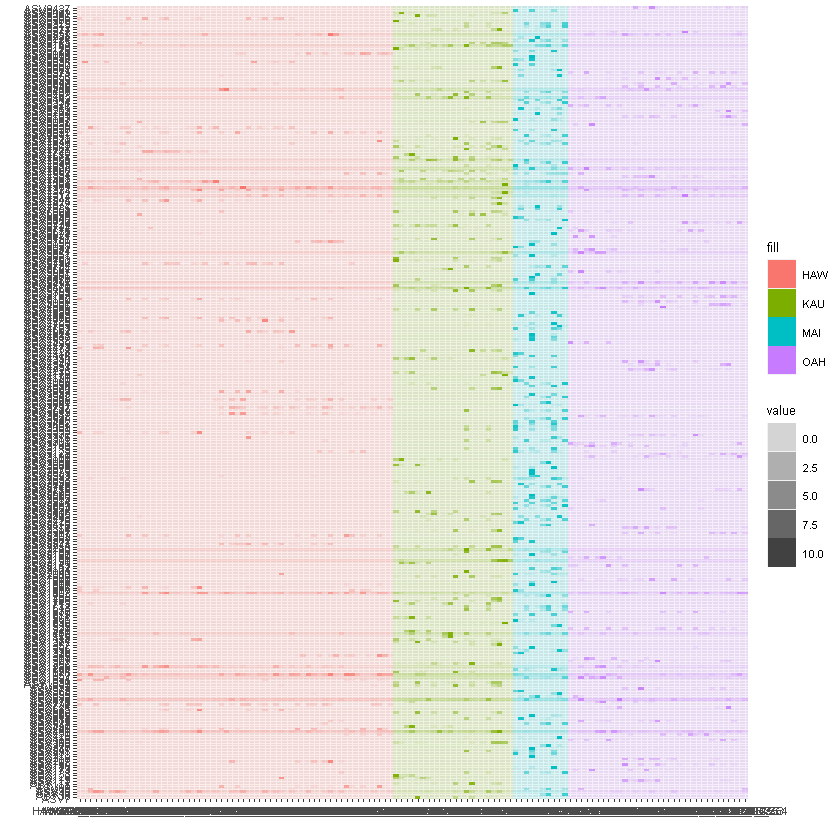

In [222]:
#plot the heatmap

plot_heatmap <- function (long_species_sign_df, grouping_col) {
    
     ggplot(long_species_sign_df, aes(x = Sample, y = variable))+ aes(fill="metal")+
    
    geom_tile(aes(alpha= value, fill= .data[[grouping_col]]))+ 
    labs(x="",y="")+
      scale_y_discrete(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0))+
    theme_grey(base_size=8)
    
}

plot_heatmap(long_species_sign_df, "Island")